<a href="https://colab.research.google.com/github/eemaansheikh/Data_Science_2025/blob/main/EemaanSheikh_Unit4Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Context: I used the available basketball data set to complete this project since it's more likely to reflect a higher level of accuracy than manually collected data. This project predicts the total rebounds gained by each player's position.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import graphviz as gv
import pymc as pm

In [3]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://github.com/eemaansheikh/Data_Science_2025/raw/main/data.xlsx'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_excel(url_cs)

In [ ]:
cs_data

<Axes: ylabel='TRB'>

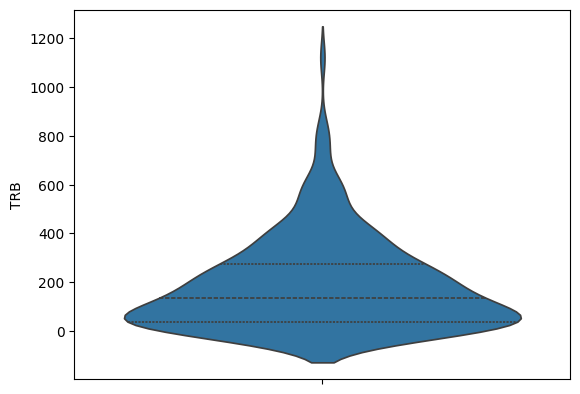

In [5]:
sns.violinplot(cs_data.TRB,inner='quart')


The violin plot above represents the rebounds gained as a function of the player's position. Due to the clear right skew of the data, I believe a Gamma or Exponential prior will be a fitting representation of the dataset.

In [6]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = cs_data.Pos.astype('category').cat.codes.values

#an array of the four strings that represent position
pos_codes = cs_data.Pos.astype('category').cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyperprior
    #
    a = pm.Gamma('μ', alpha = 0.5, beta = 1)
    b = pm.Gamma('ν', alpha = 0.5, beta = 1)

    #prior
    λ = pm.Exponential('λ', lam = a)


    #This tells our model how many shots and goals each player has
    _ = pm.Exponential('trb', lam = λ, observed = cs_data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

In [ ]:
pm.sample_posterior_predictive(idata_sccr, model=sccr_model, extend_inferencedata=True)


(0.0, 1100.0)

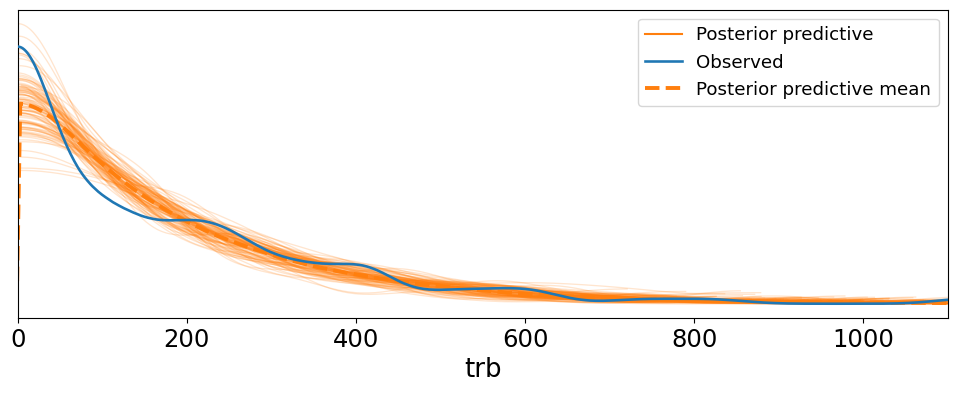

In [27]:
ax = az.plot_ppc(idata_sccr, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0, 1100)

Both, Exponential and Gamma priors were strong representations of the posterior predicitive. I also experimented with a HalfStudentT distribution to better align the prior with the posterior predictive, and adding that in definitely improved the fit. The final hierarchical posterior predictive model can be seen above.

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:

    #prior
    λ = pm.Exponential('λ', lam = 5)


    #This tells our model how many shots and goals each player has
    _ = pm.Exponential('trb', lam = λ, observed = cs_data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

In [ ]:
pm.sample_posterior_predictive(idata_sccr, model=sccr_model, extend_inferencedata=True)


(0.0, 1100.0)

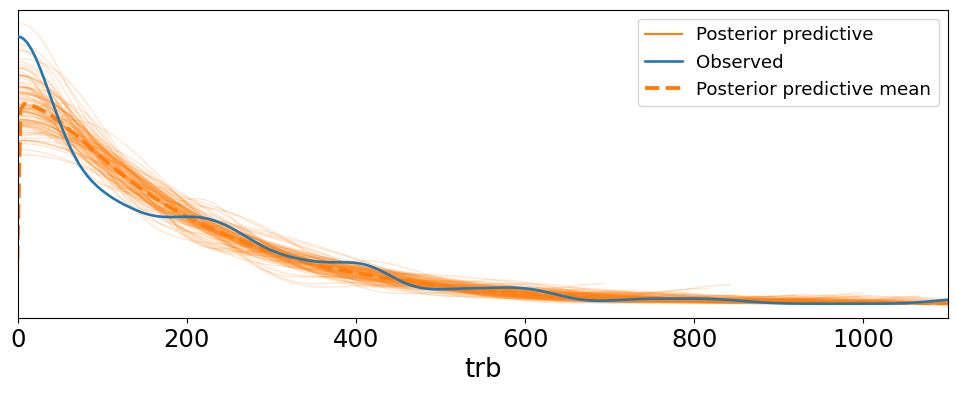

In [25]:
ax = az.plot_ppc(idata_sccr, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0, 1100)

This is the final NONhierarchical model, without the Gamma hyperprior and with only an Exponential prior. It is very similar to the hierarchical model.

array([[<Axes: title={'center': 'λ'}>, <Axes: title={'center': 'λ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>]],
      dtype=object)

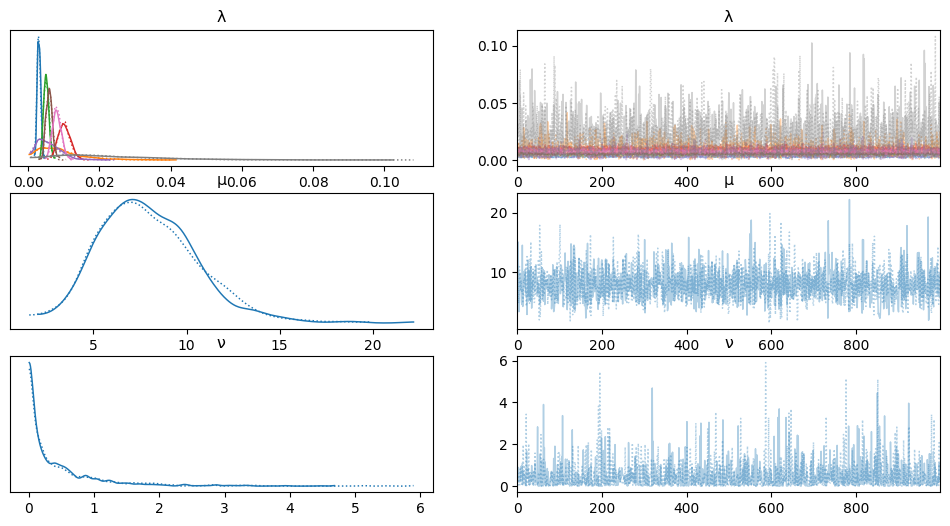

In [ ]:
az.plot_trace(idata_sccr)

array([<Axes: >], dtype=object)

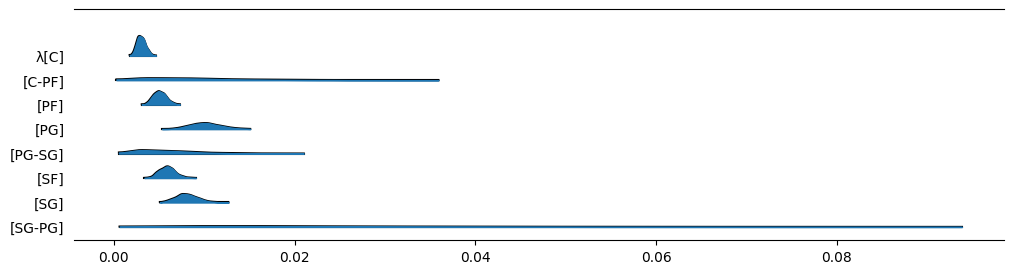

In [ ]:
az.plot_forest(idata_sccr, var_names=['λ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)


Conclusion:
Both, the hierarchical and nonhierearchical models were visually very similar and fairly accurate in terms of alignment of priors/hyperpriors and posterior predictive means. I think I had good judgement on which priors to use when analyzing the violin plot to have a right skew, which helped the accuracy of the posterior predictive model.